In [37]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import plotly.express as px
import plotly.graph_objects as go

## Load  / Prep Data

In [4]:
treedf = pd.read_csv('categorized_data.csv')
treedf.head().T

,0,1,2,3,4
Unnamed: 0,1,2,4,5,7
site,AK,AK,AK,AK,AK
tree,1A,1A,1A,1A,1A
plot,1,1,1,1,1
species,P glauca,P glauca,P glauca,P glauca,P glauca
Date,2019-01-01,2019-02-01,2019-05-01,2019-06-01,2018-07-01
longitude,-149.71571,-149.71571,-149.71571,-149.71571,-149.71571
latitude,68.018576,68.018576,68.018576,68.018576,68.018576
da,1,1,1,1,1
mo,1,2,5,6,7


In [5]:
print(treedf.columns)

Index(['Unnamed: 0', 'site', 'tree', 'plot', 'species', 'Date', 'longitude',
       'latitude', 'da', 'mo', 'wk', 'yr', 'average_stem_radius',
       'change_stem_radius', 'average_basal_area', 'change_basal_area',
       'average_air_temperature', 'average_air_pressure', 'average_humidity',
       'avg_solar_irradiance', 'avg_soil_water_content', 'freeze_flag',
       'air_pressure_cat', 'humidity_cat', 'solar_rank', 'solar_cat',
       'soil_moist_cat', 'growth_category'],
      dtype='object')


In [11]:
X = treedf[["plot", "average_stem_radius", "change_stem_radius", "average_basal_area", \
           "average_air_temperature", "average_air_pressure", "average_humidity", "avg_solar_irradiance", \
           "avg_soil_water_content", "freeze_flag"]].dropna()

In [12]:
corr_X = X.corr()

fig_corr_X = px.imshow(
    corr_X,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    aspect="auto",
    title="Correlation Matrix of Original Variables"
)
fig_corr_X.update_layout(
    width=900,
    height=900,
)
fig_corr_X.show()

## Creating Model

In [13]:
pca_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca", PCA())
])

pca_pipe.fit(X)

,steps,"[('scaler', ...), ('pca', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'


In [68]:
pca_model = pca_pipe.named_steps["pca"]
explained_var = pca_model.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)
n_components = len(explained_var)

ev_df = pd.DataFrame({
    "PC": np.arange(1, n_components + 1),
    "ExplainedVariance": explained_var,
    "CumulativeVariance": cum_explained_var
})


fig_scree = px.line(
    ev_df, x="PC", y="ExplainedVariance",
    markers=True,
    title="Scree Plot: Proportion of Variance Explained"
)

print(explained_var)
print(cum_explained_var)

[0.30142774 0.20673918 0.12942052 0.11260854 0.09388906 0.07028535
 0.04685202 0.02159173 0.01524711 0.00193876]
[0.30142774 0.50816692 0.63758744 0.75019598 0.84408504 0.91437039
 0.9612224  0.98281413 0.99806124 1.        ]


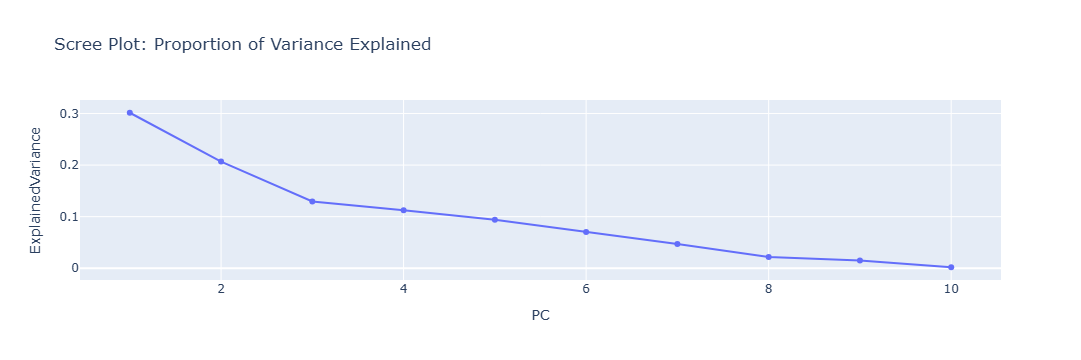

In [66]:
fig_scree.show()

In [71]:
X_pca_scores = pca_pipe.transform(X)
#pc_cols = [f"PC{i}" for i in range(1, n_components + 1)]

# Get indices of components > 0.09
important_indices = [i for i, var in enumerate(explained_var) if var > 0.09]
# Keep only PCs where explained variance > 0.09
pc_cols = [f"PC{i+1}" for i in important_indices]

scores_df = pd.DataFrame(X_pca_scores[:, important_indices], columns=pc_cols)
scores_df

print(len(scores_df))
print(len(scores_df.dropna()))

13637
13637


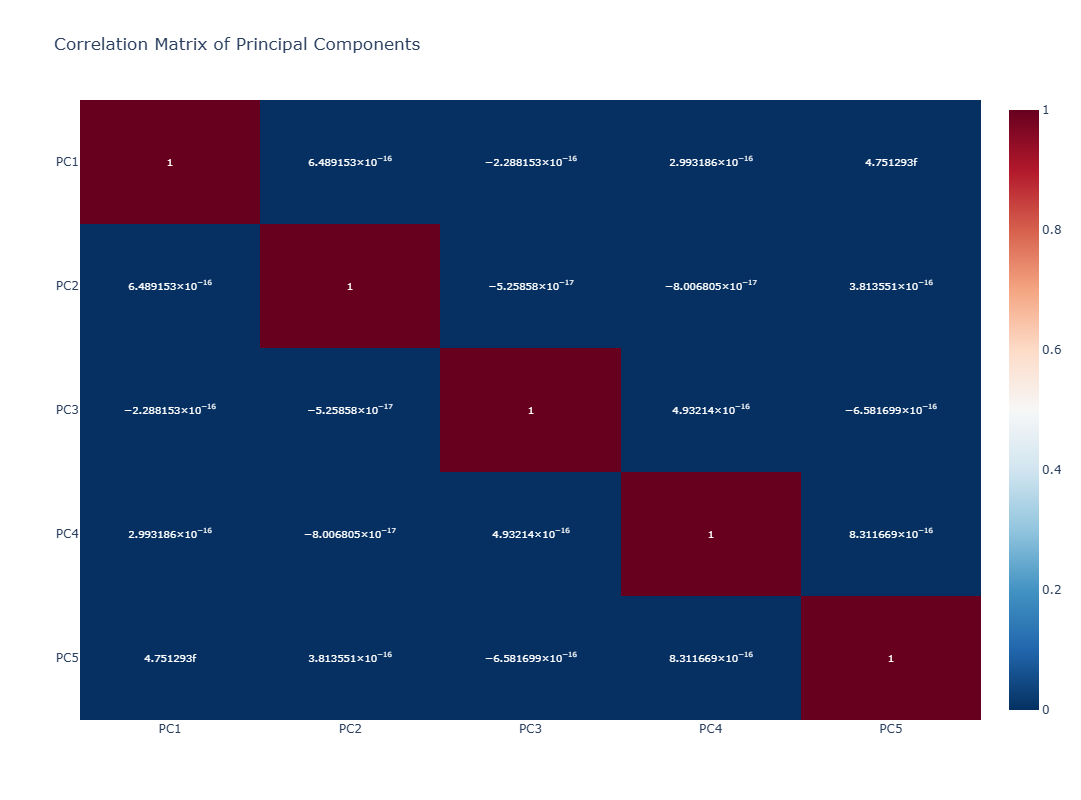

In [72]:
corr_PC = scores_df.corr()

fig_corr_PC = px.imshow(
    corr_PC,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    aspect="auto",
    title="Correlation Matrix of Principal Components"
)
fig_corr_PC.update_layout(
    width=800,
    height=800,
)
fig_corr_PC.show()

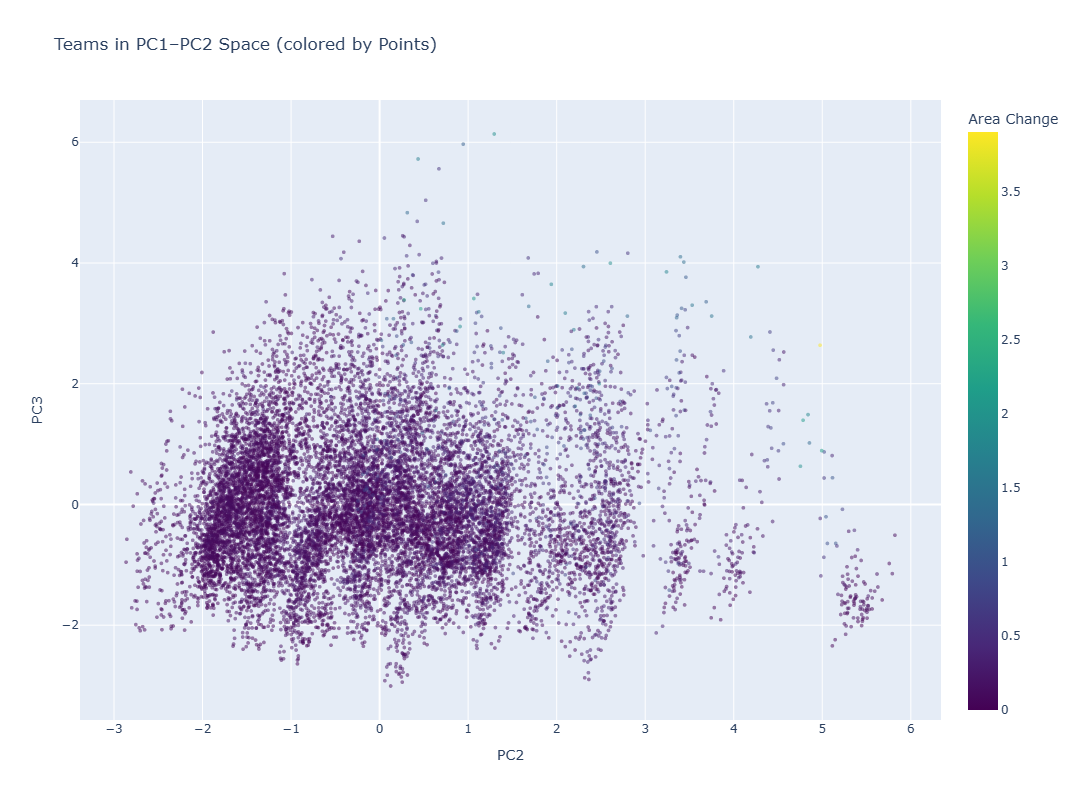

In [79]:
X_pca_scores = pca_pipe.transform(X)

# Get indices of components > 0.09
important_indices = [i for i, var in enumerate(explained_var) if var > 0.09]
# Keep only PCs where explained variance > 0.09
pc_cols = [f"PC{i+1}" for i in important_indices]

X_pca_scores = X_pca_scores[:, important_indices]

scores_df = pd.DataFrame(X_pca_scores, columns=pc_cols)
scores_df["Area Change"] = treedf['change_basal_area']
scores_df['species'] = treedf['species']
scores_df['plot'] = treedf['plot']
scores_df['Date'] = treedf['Date']

fig_scatter = px.scatter(
    scores_df,
    x="PC2", y="PC3",
    color="Area Change",
    hover_name="species",
    hover_data="Date",
    title="Teams in PC1–PC2 Space (colored by Points)",
    color_continuous_scale="Viridis",
    width=800,
    height=800,
    opacity=0.5
)

fig_scatter.update_traces(marker=dict(size=4)) 

fig_scatter.show()

## Investigating the Principal Components

In [80]:
# treedf columns
'''
['Unnamed: 0', 'site', 'tree', 'plot', 'species', 'Date', 'longitude',
       'latitude', 'da', 'mo', 'wk', 'yr', 'average_stem_radius',
       'change_stem_radius', 'average_basal_area', 'change_basal_area',
       'average_soil_temperature', 'average_air_pressure', 'average_humidity',
       'avg_solar_irradiance', 'avg_soil_water_content', 'freeze_flag',
       'air_pressure_cat', 'humidity_cat', 'solar_cat', 'soil_moist_cat']
'''

"\n['Unnamed: 0', 'site', 'tree', 'plot', 'species', 'Date', 'longitude',\n       'latitude', 'da', 'mo', 'wk', 'yr', 'average_stem_radius',\n       'change_stem_radius', 'average_basal_area', 'change_basal_area',\n       'average_soil_temperature', 'average_air_pressure', 'average_humidity',\n       'avg_solar_irradiance', 'avg_soil_water_content', 'freeze_flag',\n       'air_pressure_cat', 'humidity_cat', 'solar_cat', 'soil_moist_cat']\n"

In [81]:
print(scores_df.shape)
scores_df.columns

(13637, 9)


Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'Area Change', 'species', 'plot',
       'Date'],
      dtype='object')

In [82]:
print(treedf.shape)

(13637, 28)


In [83]:
result = pd.concat([treedf, scores_df],axis=1)
result.sort_values('change_stem_radius', ascending=False).tail(20).T

,1950,1893,9673,9676,9677,900,9680,12324,12343,12354,1939,9604,9607,988,935,945,12196,12197,1829,9678
Unnamed: 0,3369,3287,15839,15844,15845,1639,15851,23311,23397,23443,3354,15711,15717,1803,1703,1723,22689,22690,3189,15847
site,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK
tree,1F,1F,3A,3A,3A,1C,3A,5E,5E,5E,1F,3A,3A,1D,1C,1C,5C,5C,1F,3A
plot,1,1,3,3,3,1,3,5,5,5,1,3,3,1,1,1,5,5,1,3
species,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca
Date,2019-05-26,2019-05-20,2018-06-24,2017-08-24,2017-09-24,2019-02-25,2018-02-25,2019-02-08,2019-01-12,2019-02-14,2019-02-25,2017-12-18,2018-03-19,2018-12-01,2019-01-28,2018-12-28,2019-01-19,2019-02-19,2018-07-13,2017-12-24
longitude,-149.71558,-149.71558,-149.75301,-149.75301,-149.75301,-149.71584,-149.75301,-149.76123,-149.76123,-149.76123,-149.71558,-149.75301,-149.75301,-149.71586,-149.71584,-149.71584,-149.76131,-149.76131,-149.71558,-149.75301
latitude,68.018659,68.018659,67.995233,67.995233,67.995233,68.018696,67.995233,67.984808,67.984808,67.984808,68.018659,67.995233,67.995233,68.018735,68.018696,68.018696,67.984964,67.984964,68.018659,67.995233
da,26,20,24,24,24,25,25,8,12,14,25,18,19,1,28,28,19,19,13,24
mo,5,5,6,8,9,2,2,2,1,2,2,12,3,12,1,12,1,2,7,12


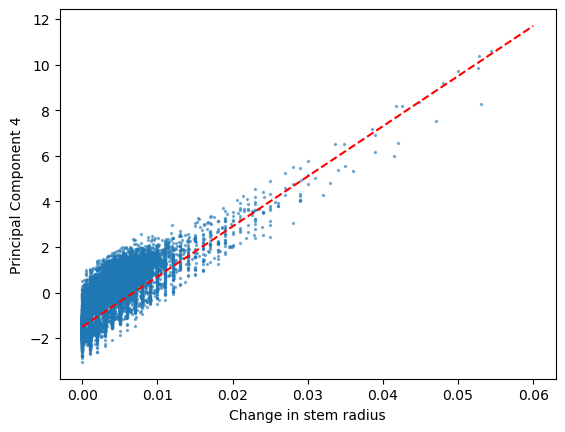

In [53]:
x = result['change_stem_radius']
y = result['PC4']
plt.scatter(x,y, alpha=0.5, s=2)
plt.xlabel('Change in stem radius')
plt.ylabel('Principal Component 4')

line1 = np.linspace(0,0.06,20)
line2 = 220*line1-1.5
plt.plot(line1,line2,c='r',linestyle='--')

## Loadings

In [54]:
loadings = pca_model.components_.T[:, :2]
loading_df = pd.DataFrame(
    loadings,
    index=X.columns,
    columns=["PC1_loading", "PC2_loading"]
)

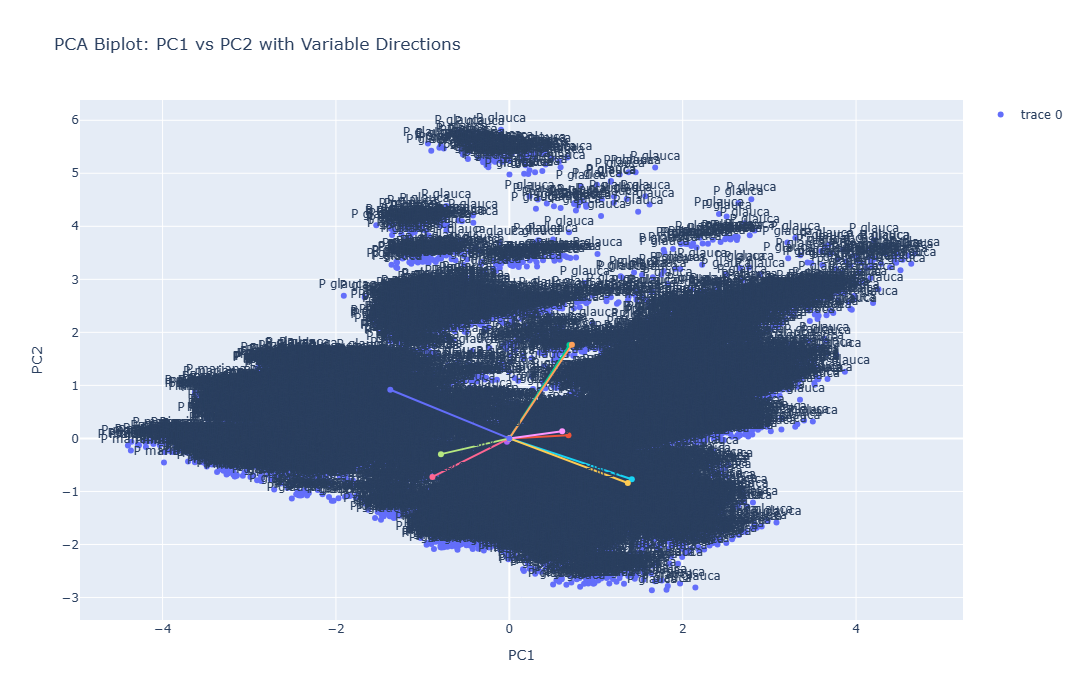

In [61]:
arrow_scale = 3

fig = go.Figure()


fig.add_trace(go.Scatter(
    x=result["PC1"],
    y=result["PC2"],
    mode="markers+text",
    text=result["species"],
    textposition="top center",
    #name="species",
    #hovertext=[f"{t}, Points={p}" for t, p in zip(result["species"], result["change_stem_radius"])],
    #hoverinfo="text"
))


for var_name, row in loading_df.iterrows():
    x_arrow = row["PC1_loading"] * arrow_scale
    y_arrow = row["PC2_loading"] * arrow_scale


    fig.add_trace(go.Scatter(
        x=[0, x_arrow],
        y=[0, y_arrow],
        mode="lines+markers+text",
        text=[None, var_name],
        textposition="top center",
        showlegend=False
    ))

fig.update_layout(
    title="PCA Biplot: PC1 vs PC2 with Variable Directions",
    xaxis_title="PC1",
    yaxis_title="PC2",
    xaxis=dict(zeroline=True),
    yaxis=dict(zeroline=True),
    width=800,
    height=700
)

fig.show()


In [ ]:


pca = pca_pipe.named_steps["pca"]

scores = pca_pipe.transform(X)
pc1 = scores[:, 0]
pc2 = scores[:, 1]


score_scaler = StandardScaler()
scores_std = score_scaler.fit_transform(np.column_stack([pc1, pc2]))

pc1_std = scores_std[:, 0]
pc2_std = scores_std[:, 1]

scores_df = pd.DataFrame({
    "PC1_std": pc1_std,
    "PC2_std": pc2_std
})


team_col = laliga.select_dtypes(exclude=['number']).columns[0]
scores_df["Team"] = laliga[team_col]

if "Points" in laliga.columns:
    scores_df["Points"] = laliga["Points"]


loadings = pca.components_.T

loading_pc1 = loadings[:, 0]
loading_pc2 = loadings[:, 1]


loading_scaler = StandardScaler()
load_std = loading_scaler.fit_transform(
    np.column_stack([loading_pc1, loading_pc2])
)

loading_pc1_std = load_std[:, 0]
loading_pc2_std = load_std[:, 1]

loading_df = pd.DataFrame({
    "var": X.columns,
    "PC1_std": loading_pc1_std,
    "PC2_std": loading_pc2_std
})



In [ ]:
arrow_scale = 1.8


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=scores_df["PC1_std"],
    y=scores_df["PC2_std"],
    mode="markers+text",
    text=scores_df["Team"],
    textposition="top center",
    name="Teams",
    marker=dict(size=8, color="blue")
))


for i, row in loading_df.iterrows():
    fig.add_trace(go.Scatter(
        x=[0, row["PC1_std"] * arrow_scale],
        y=[0, row["PC2_std"] * arrow_scale],
        mode="lines+markers+text",
        text=[None, row["var"]],
        textposition="top center",
        line=dict(color="red"),
        marker=dict(size=5, color="red"),
        showlegend=False
    ))


fig.update_layout(
    title="Standardized PCA Biplot: PC1 vs PC2 (Plotly)",
    xaxis_title="PC1 (standardized)",
    yaxis_title="PC2 (standardized)",
    width=900,
    height=800,
    xaxis=dict(zeroline=True),
    yaxis=dict(zeroline=True),
)

fig.show()

In [ ]:
pca = pca_pipe.named_steps["pca"]

scores = pca_pipe.transform(X)
pc1 = scores[:, 0]
pc3 = scores[:, 2]


score_scaler = StandardScaler()
scores_std = score_scaler.fit_transform(np.column_stack([pc1, pc3]))

pc1_std = scores_std[:, 0]
pc3_std = scores_std[:, 1]

scores_df = pd.DataFrame({
    "PC1_std": pc1_std,
    "PC3_std": pc3_std
})


team_col = laliga.select_dtypes(exclude=['number']).columns[0]
scores_df["Team"] = laliga[team_col]


loadings = pca.components_.T

loading_pc1 = loadings[:, 0]
loading_pc3 = loadings[:, 2]


loading_scaler = StandardScaler()
load_std = loading_scaler.fit_transform(
    np.column_stack([loading_pc1, loading_pc3])
)

loading_pc1_std = load_std[:, 0]
loading_pc3_std = load_std[:, 1]

loading_df = pd.DataFrame({
    "var": X.columns,
    "PC1_std": loading_pc1_std,
    "PC3_std": loading_pc3_std
})



In [ ]:

arrow_scale = 1.8


fig = go.Figure()


fig.add_trace(go.Scatter(
    x=scores_df["PC1_std"],
    y=scores_df["PC3_std"],
    mode="markers+text",
    text=scores_df["Team"],
    textposition="top center",
    name="Teams",
    marker=dict(size=8, color="blue")
))


for i, row in loading_df.iterrows():
    fig.add_trace(go.Scatter(
        x=[0, row["PC1_std"] * arrow_scale],
        y=[0, row["PC3_std"] * arrow_scale],
        mode="lines+markers+text",
        text=[None, row["var"]],
        textposition="top center",
        line=dict(color="red"),
        marker=dict(size=5, color="red"),
        showlegend=False
    ))


fig.update_layout(
    title="Standardized PCA Biplot: PC1 vs PC3 (Plotly)",
    xaxis_title="PC1 (standardized)",
    yaxis_title="PC3 (standardized)",
    width=900,
    height=800,
    xaxis=dict(zeroline=True),
    yaxis=dict(zeroline=True)
)

fig.show()

## Principal Component REGRESSION

In [62]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

pcr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=4)),
    ("linreg", LinearRegression())
])


pcr_pipe.fit(X_train, y_train)


,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,4
,copy,True
,whiten,False
,svd_solver,'auto'


In [64]:
train_r2 = pcr_pipe.score(X_train, y_train)
test_r2  = pcr_pipe.score(X_test, y_test)


y_train_pred = pcr_pipe.predict(X_train)
y_test_pred  = pcr_pipe.predict(X_test)

In [65]:
train_rmse = np.sqrt(np.mean((y_train - y_train_pred)**2))
test_rmse  = np.sqrt(np.mean((y_test - y_test_pred)**2))

print(f"Using n_components = {4}")
print(f"Train R²  : {train_r2:.4f}")
print(f"Test  R²  : {test_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test  RMSE: {test_rmse:.4f}")

Using n_components = 4
Train R²  : 0.9996
Test  R²  : 0.9996
Train RMSE: 0.0210
Test  RMSE: 0.0216


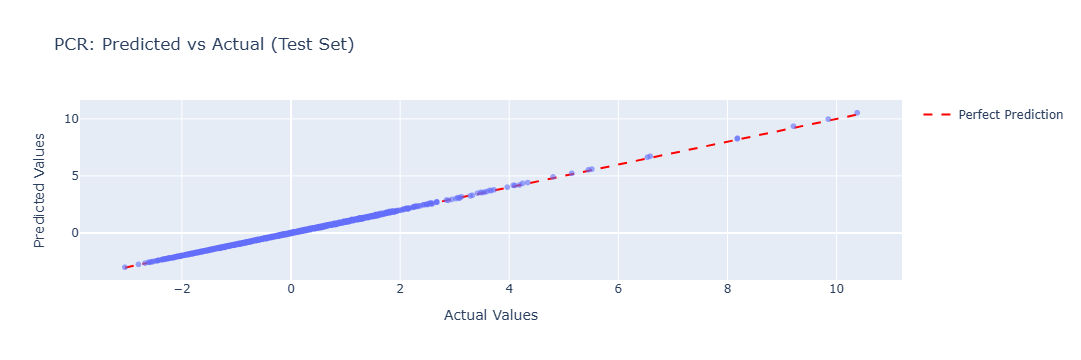

In [84]:
import plotly.express as px

# Predicted vs Actual plot for test data
fig = px.scatter(
    x=y_test, 
    y=y_test_pred,
    labels={'x': 'Actual Values', 'y': 'Predicted Values'},
    title='PCR: Predicted vs Actual (Test Set)',
    opacity=0.6
)

# Add perfect prediction line (y=x)
fig.add_scatter(
    x=[y_test.min(), y_test.max()],
    y=[y_test.min(), y_test.max()],
    mode='lines',
    name='Perfect Prediction',
    line=dict(color='red', dash='dash')
)

fig.show()